In [1]:
import sys
import pathlib
sys.path.append(str(pathlib.PurePath(pathlib.Path.cwd().parent)))

import numpy as np
import scipy
import matplotlib.pyplot as plt
import time

from src.particle_funcs import distance_matrix as distance_matrix
import src.leap_funcs.qubo.q_matrix as q_matrix

import gurobipy

[1. 0. 0. ... 0. 0. 1.]


C:\Users\oahre\AppData\Local\Temp\ipykernel_16232\3082771223.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_initial.show()


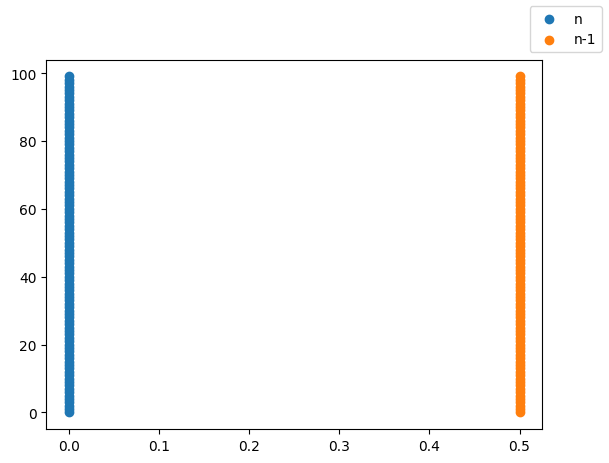

In [2]:
num_particles = 100

use_dimod_exact_solver = False

part_coords_n = np.zeros((num_particles,2))
part_coords_nm1 = np.zeros((num_particles,2))

for i in range(np.shape(part_coords_n)[0]):
    part_coords_n[i,:] = [0, i]
    part_coords_nm1[i,:] = [0.5*1, i]

fig_initial, axs_initial = plt.subplots(1,1)
axs_initial.scatter(part_coords_n[:,0], part_coords_n[:,1], label="n")
axs_initial.scatter(part_coords_nm1[:,0], part_coords_nm1[:,1], label="n-1")
fig_initial.legend()
fig_initial.show()

correct_sol = np.zeros(num_particles*num_particles)
for i in range(1, num_particles+1):
    correct_sol[(i-1)*num_particles + i -1] = 1.

print(correct_sol)

In [3]:
distances = distance_matrix.calc_phi_ij(part_coords_n, part_coords_nm1)
Q_dist_diag = q_matrix.q_dist_diag(distances)
assert (Q_dist_diag.transpose() == Q_dist_diag).all(), 'Q_dist is not symmetric'
with np.printoptions(precision=3):
    print(Q_dist_diag)
Q_part = q_matrix.q_part(np.shape(distances)[0])
print(Q_part)
#assert (Q_part.transpose() == Q_part).all(), 'Q_part is not symmetric'
# changed to only return upper triangular part, so is definitely not symmetric
Q_pos = q_matrix.q_pos(np.shape(distances)[0])
Q_pos = q_matrix.q_pos(np.shape(distances)[0])
print(Q_pos)
#assert (Q_pos.transpose() == Q_pos).all(), 'Q_pos is not symmetric'
# changed to only return upper triangular part, so is definitely not symmetric

[[0.5   0.    0.    ... 0.    0.    0.   ]
 [0.    1.118 0.    ... 0.    0.    0.   ]
 [0.    0.    2.062 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 2.062 0.    0.   ]
 [0.    0.    0.    ... 0.    1.118 0.   ]
 [0.    0.    0.    ... 0.    0.    0.5  ]]
[[-1.  4.  4. ...  0.  0.  0.]
 [ 0. -1.  4. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  4.  4.]
 [ 0.  0.  0. ...  0. -1.  4.]
 [ 0.  0.  0. ...  0.  0. -1.]]
[[-1.  0.  0. ...  0.  0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]]


In [4]:
Q_array = Q_dist_diag + Q_part + Q_pos

with np.printoptions(precision=3, suppress=True):
    print(Q_array)

[[-1.5    4.     4.    ...  0.     0.     0.   ]
 [ 0.    -0.882  4.    ...  0.     0.     0.   ]
 [ 0.     0.     0.062 ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ...  0.062  4.     4.   ]
 [ 0.     0.     0.    ...  0.    -0.882  4.   ]
 [ 0.     0.     0.    ...  0.     0.    -1.5  ]]


In [5]:
#Q_dict = q_matrix.Q_convert_to_dict(Q_array)
#Q_dict = q_matrix.Q_convert_to_dict(Q_array_rem)
#print(Q_dict)

In [6]:
gurobi_model = gurobipy.Model()
x = gurobi_model.addMVar(num_particles*num_particles, vtype='b', name='x')
#Q = gurobi_model.addMVar(Q_array, name='Q')
gurobi_model.setObjective(x @ Q_array @ x)
print('    NumVars = ',gurobi_model.NumVars)
gurobi_model.optimize()
print('    NumVars = ',gurobi_model.NumVars)
print(x.X)
print()
print ('Is solution correct? --> ', (x.X == correct_sol).all())
print('Runtime = ', gurobi_model.Runtime)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2450895
Academic license 2450895 - for non-commercial use only - registered to ol___@rwth-aachen.de
    NumVars =  0
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2450895 - for non-commercial use only - registered to ol___@rwth-aachen.de
Optimize a model with 0 rows, 10000 columns and 0 nonzeros
Model fingerprint: 0xc8ef98b6
Model has 1000000 quadratic objective terms
Variable types: 0 continuous, 10000 integer (10000 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Found heuristic solution: obj

In [7]:
scipy_tic = time.time()
scipy_row_ind, scipy_col_ind = scipy.optimize.linear_sum_assignment(distances)
scipy_toc = time.time()
scipy_runtime = scipy_toc - scipy_tic
scipy_x = np.zeros(num_particles*num_particles)
for i in range(len(scipy_row_ind)):
    scipy_x[scipy_row_ind[i]*num_particles + scipy_col_ind[i]] = 1
print(scipy_x)
print()
print ('Is solution correct? --> ', (x.X == correct_sol).all())
print('Runtime = ', scipy_runtime)

[1. 0. 0. ... 0. 0. 1.]

Is solution correct? -->  True
Runtime =  0.15299534797668457
